In [1]:
import os
import scipy
import pickle
import numpy as np
from tqdm import tqdm
import multiprocessing
from skimage import io
from tqdm import tqdm
from itertools import repeat
from functools import partial
from metadata import Metadata
from scipy.spatial import KDTree
from sklearn.cluster import DBSCAN
from skimage.transform import resize
from skimage.filters import gaussian
from collections import Counter, defaultdict
from skimage.feature import match_template, peak_local_max

In [16]:
class Registration_Class(object):
    def __init__(self,stk,posname,hybe,ref_hybe='hybe1',verbose=False,registration_threshold=2,upsamp_factor=5,dbscan_eps=3, dbscan_min_samples=20,max_dist=200,match_threshold=0.65):
        self.stk = stk
        self.posname = posname
        self.hybe = hybe
        if self.hybe == ref_hybe:
            self.ref = True
        else:
            self.ref = False
        self.registration_threshold = registration_threshold
        self.upsamp_factor = upsamp_factor
        self.dbscan_eps = dbscan_eps
        self.dbscan_min_samples = dbscan_min_samples
        self.max_dist = max_dist
        self.match_threshold = match_threshold
        self.verbose=verbose
        
    def run(self):
        self.generate_template()
        self.find_beads()
#         self.save_beads()
        self.find_tforms()
#         self.save_tforms()

    def generate_template(self):
        #Create Bead Template
        bead = np.zeros((7, 7, 5))
        bead[3, 3, 2] = 1
        bead = gaussian(bead, (1.5, 1.5, 0.85))
        Ave_Bead = bead/bead.max()
        self.bead_template = Ave_Bead
        self.upsamp_bead = resize(self.bead_template[2:5, 2:5, 1:4],
                             (3*self.upsamp_factor, 3*self.upsamp_factor, 3*self.upsamp_factor),
                             mode='constant',anti_aliasing=False)
        
    def find_beads(self):
        """
        3D registration from sparse bead images.
        Parameters
        ----------
        fnames_dict : dict
            Dictionary (hybe name:list filenames) to load bead images
        bead_template : numpy.array
            Array of normalized values of 'average bead' intensities.
            This helps to not pick up noisy spots/hot pixels.
        ref_reference : str - default('hybe1')
            Which hybe is the reference destination to map source hybes onto.
        max_dist : int - default(50)
            The maximum distanced allowed between beads found when pairing 
            beads between multiple hybes.
        match_threshold : float - default(0.75)
            The similarity threshold between bead_template and images to 
            consider potential beads.
        Returns
        -------
        tforms : dict
            Dictionary of translation vectors (x, y, z)? maybe (y, x, z)
        """
        if self.verbose:
            print('Matching Template')
        ref_match = match_template(self.stk, self.bead_template, pad_input=True)
        if self.verbose:
            print('Finding Peaks')
        ref_beads = peak_local_max(ref_match, threshold_abs=self.match_threshold)
        subpixel_beads = []
        if self.verbose:
            iterable = tqdm(ref_beads,desc='Finding Subpixel Centers')
        else:
            iterable = ref_beads
        for y, x, z in iterable:
            substk = self.stk[y-5:y+6, x-5:x+6, z-2:z+3]
            if substk.shape[0] != 11 or substk.shape[1] != 11:
                continue # candidate too close to edge
            try:
                upsamp_substk = resize(substk,
                                       (substk.shape[0]*self.upsamp_factor,
                                        substk.shape[1]*self.upsamp_factor,
                                        substk.shape[2]*self.upsamp_factor),
                                       mode='constant',anti_aliasing=False)
            except:
                continue
            bead_match = match_template(upsamp_substk,
                                        self.upsamp_bead, pad_input=True)
            yu, xu, zu = np.where(bead_match==bead_match.max())
            yu = (yu[0]-int(upsamp_substk.shape[0]/2))/self.upsamp_factor
            xu = (xu[0]-int(upsamp_substk.shape[1]/2))/self.upsamp_factor
            zu = (zu[0]-int(upsamp_substk.shape[2]/2))/self.upsamp_factor
            ys, xs, zs = (yu+y, xu+x, zu+z)
            subpixel_beads.append((ys, xs, zs))
        self.coordinates = subpixel_beads

    def find_tforms(self):
        if self.ref:
            self.generate_reference_hybe()
        else:
            self.calculate_transformation()
            
    def generate_reference_hybe(self):
        ref_beadarray = np.stack(self.coordinates,axis=0)
        ref_tree = KDTree(ref_beadarray[:, :2])
        db_clusts = DBSCAN(min_samples=self.dbscan_min_samples, eps=self.dbscan_eps)
        self.reference_beads = ref_beadarray
        self.reference_tree = ref_tree
        self.db_clusters = db_clusts
        self.translation_x = 0
        self.translation_y = 0
        self.translation_z = 0
        self.residual = 0
        self.nbeads = ref_beadarray.shape[0]
        if self.nbeads<self.dbscan_min_samples:
            self.passed = False
            self.error = 'Not enough reference beads found.'
        else:
            self.passed = True
        
    def calculate_transformation(self,max_dist=200, dbscan_min_samples=20):
        """
        Calculate transformation to register 2 sets of images together
        Given a set of candidate bead coordinates (xyz) and a reference hybe find min-error translation.

        This task is trivial given a paired set of coordinates for source/destination beads. 
        The input to this function is unpaired so the first task is pairing beads. Given the 
        density of beads in relation to the average distance between beads it is not reliable to 
        simply use closest-bead-candidate pairing. However, for each bead in the destination we can find 
        all beads within from distance in the source set of beads and calculate the difference of all these pairs.
        Bead pairs that are incorrect have randomly distributed differences however correct bead pairs all 
        have very similar differences. So a density clustering of the differences is performed to identify 
        the set of bead pairings representing true bead pairs between source/destination.

        The best translation is found my minimizing the mean-squared error between source/destination after pairing.
        """
        self.passed = True
        ref_beadarray = self.reference_beads
        ref_tree = self.reference_tree
        db_clusts = self.db_clusters
        beadarray = np.stack(self.coordinates, axis=0)
        t_est = []
        ref_beads = []
        dest_beads = []
        close_beads = ref_tree.query_ball_point(beadarray[:, :2], r=max_dist)
        if self.verbose:
            iterable = tqdm(zip(close_beads, beadarray),total=beadarray.shape[0],desc='Calculating Transformation')
        else:
            iterable = zip(close_beads, beadarray)
        for i, bead in iterable:
            if len(i)==0:
                continue
            for nbor in i:
                t = ref_beadarray[nbor]-bead
                t_est.append(np.subtract(ref_beadarray[nbor], bead))
                ref_beads.append(ref_beadarray[nbor])
                dest_beads.append(bead)
        ref_beads = np.array(ref_beads)
        dest_beads = np.array(dest_beads)
        if len(t_est)<self.dbscan_min_samples:
            self.passed = False
            self.error = 'Not enough bead pairs found.'
        if self.passed:
            t_est = np.stack(t_est, axis=0)
            db_clusts.fit(t_est)
            most_frequent_cluster = Counter(db_clusts.labels_)
            most_frequent_cluster.pop(-1)
            try:
                most_frequent_cluster = most_frequent_cluster.most_common(1)[0][0]
            except IndexError:
                self.error = 'Not enough bead pairs found.'
                self.passed = False
        if self.passed:
            paired_beads_idx = db_clusts.labels_==most_frequent_cluster
            ref = ref_beads[paired_beads_idx]
            dest = dest_beads[paired_beads_idx]
            t_est = t_est[paired_beads_idx]
            def error_func(translation):
                fit = np.add(translation, dest)
                fit_error = np.sqrt(np.subtract(ref, fit)**2)
                fit_error = np.mean(fit_error)
                return fit_error
            # Optimize translation to map paired beads onto each other
            opt_t = scipy.optimize.fmin(error_func, np.mean(t_est, axis=0), full_output=True, disp=False)
#             tform_dict[h] = (opt_t[0], opt_t[1], sum(paired_beads_idx))
            if opt_t[1]>self.registration_threshold:
                self.error = 'Residual too high'
                self.passed = False
            self.translation_x = opt_t[0][1]
            self.translation_y = opt_t[0][0]
            self.translation_z = opt_t[0][2]
            self.residual = opt_t[1]
            self.nbeads = sum(paired_beads_idx)
            

In [10]:
def error_func(translation):
    fit = np.add(translation, dest)
    fit_error = np.sqrt(np.subtract(ref, fit)**2)
    fit_error = np.mean(fit_error)
    return fit_error

/home/zach/miniconda3/envs/pyspots-gpu/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


opening img_Pos1_000000033_000000000_DeepBlue_000_033.tif

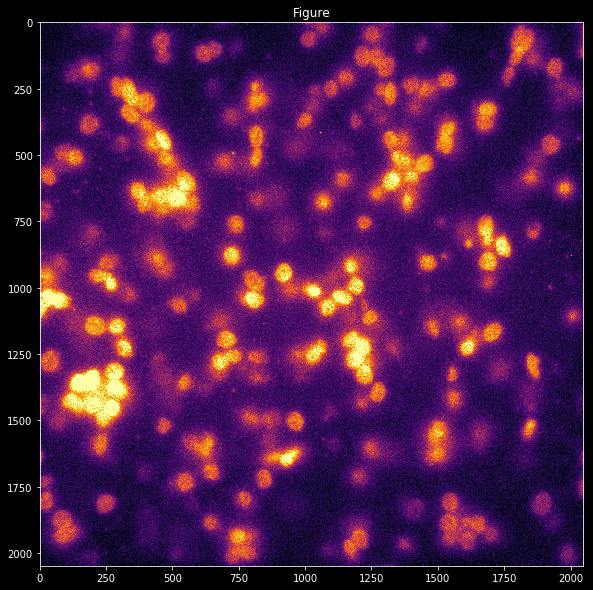

In [6]:
md_path = '/hybedata/Images/Zach/ZebraFinch/A4_2020Jun28/'
md = Metadata(md_path)
posname = 'Pos1'
beads = pickle.load(open(os.path.join(md_path,'results','beads.pkl'),'rb'))
tforms = pickle.load(open(os.path.join(md_path,'results','tforms.pkl'),'rb'))
hybe = 'hybe1'
stk = md.stkread(Position=posname,hybe=hybe,Channel='DeepBlue',verbose=True)
from fish_helpers import Display
Display(stk[:,:,19])

In [7]:
reg_class = Registration_Class(stk,posname,hybe,ref_hybe='hybe1',verbose=True)
reg_class.run()

Matching Template
Finding Peaks


Finding Beads: 100%|██████████| 435/435 [01:07<00:00,  6.43it/s]


opening img_Pos1_000000033_000000000_DeepBlue_000_033.tif

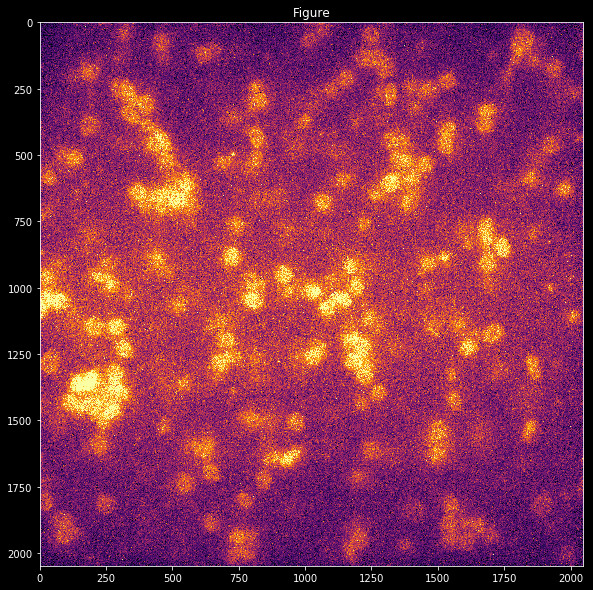

Matching Template
Finding Peaks


Finding Subpixel Centers: 100%|██████████| 405/405 [00:58<00:00,  6.90it/s]
Calculating Transformation: 402it [00:00, 9187.96it/s]


In [17]:
hybe2 = 'hybe2'
stk2 = md.stkread(Position=posname,hybe=hybe2,Channel='DeepBlue',verbose=True)
from fish_helpers import Display
Display(stk2[:,:,19])
reg_class2 = Registration_Class(stk2,posname,hybe2,ref_hybe='hybe1',verbose=True)
reg_class2.reference_beads = reg_class.reference_beads
reg_class2.reference_tree = reg_class.reference_tree
reg_class2.db_clusters = reg_class.db_clusters
reg_class2.run()

In [18]:
reg_class2.translation_x

0.19998088089509958

In [19]:
reg_class2.translation_y

-3.4018536165821045

In [20]:
reg_class2.translation_z

-1.4000355287687112

In [23]:
tforms['good'][posname][hybe2]

(array([-3.40185362,  0.19998088, -1.40003553]), 0.21817113366745355, 387)